# Learning networks in mouse S1

#### Thanks to Nick Sofroniew and Karel Svoboda for all data, experimental parameters, and `def`'ed and `helper.plots` helper functions

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [21]:
import covdict
import json
import numpy as np
import os
import pandas as pd
import scipy.stats as st
import time
from IPython.html import widgets
from helper.plots import smoothfit, tuning
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import scale

## Helper functions for loading and processing data

In [4]:
def align(table, primary, index):
    table['sourceId'] = primary['sourceId']
    table.set_index(index, inplace = True)
    table.columns = table.columns.astype('float')
    return table

In [5]:
def load(session):
    
    with open(os.path.join(path, session, 'info.json')) as infile:
        info = json.load(infile)
        
    d = {}

    # Load the units, whih have our primary keys
    d['units'] = pd.DataFrame.from_csv(os.path.join(path, session, 'tables', 'units.csv'))
    
    # Load tables   
    d['tuning'] = pd.DataFrame.from_csv(os.path.join(path, session, 'tables', 'tuning.csv'))   
    d['tuning'] = align(d['tuning'], d['units'], ['sourceId', 'label'])
    d['tuningNum'] = d['tuning'].xs('numTrials', level='label')
    err = d['tuning'].xs('stdRate', level='label').divide(d['tuningNum'].apply(np.sqrt))
    d['tuning'] = d['tuning'].xs('meanRate', level='label')
    d['tuningErr'] = err
    d['tuningSummary'] = summarize(d['tuning'])
  
    d['units'].set_index('sourceId',inplace = True)

    # Add tables
    d = pd.concat([d[x] for x in d.keys()], axis = 1, keys = d.keys())
    
    info['contributors'] = ', '.join(info['contributors'])
    info['dimensions'] = str(info['dimensions'])
    info['session'] = session
    info = pd.DataFrame(info, index = [str(info['id'])])
    
    return d, info

In [6]:
smooth = 1

def summarize(df):
    x = df.columns.values
    xs, ys = smoothfit(x, df.values[0], smooth=smooth)
    smoothed = [smoothfit(x, y, smooth=smooth)[1] for y in df.values]

    summary = pd.DataFrame(index=df.index)
    summary['Baseline'] = [y[-1] for y in smoothed]
    summary['Max'] = [max(y) for y in smoothed]
    summary['ArgMax'] = [xs[np.argmax(y)] for y in smoothed]
    summary['Min'] = [min(y) for y in smoothed]
    summary['Mean'] = [np.mean(y) for y in smoothed]

    summary['Activation'] = summary.Max - summary.Baseline
    summary['Supression'] = summary.Baseline - summary.Min
    summary['Range'] = summary.Max - summary.Min
    summary['Modulation'] = (summary.Activation - summary.Supression)/(summary.Activation + summary.Supression)
    summary['TotalModulation'] = (summary.Max - summary.Min)/(summary.Max + summary.Min)
    
    return summary

## Load data and summarize info

In [7]:
local = True
if local:
    path = '/Users/fannjiangc/data/paper.tuning/'
else:
    pass # Janelia path?

session = 13 # animal ID
data = load('%02g' % session)
table = data[0]
info = data[1]
hz = info['rate-hz'][0] # sampling frequency

#### Metadata

In [8]:
info

,animal,animal-state,contributors,date,depth-microns,dimensions,experiment,id,indicator,lab,location,method,pixels-per-micron,rate-hz,region,session
Anm_0216166,Mouse,Awake head-fixed,Nicholas Sofroniew,2013_07_17,200,"[512, 512, 0]",Tactile Virtual Reality,Anm_0216166,GCaMP6s,Svoboda Lab,Janelia Research Campus,Two-photon raster,1.15,7.1,vS1,13


#### Load behavioral covariates

In [12]:
with open(os.path.join(path, str(session), 'params', 'covariates.json')) as infile:
    covariates = json.load(infile)
covariates = pd.DataFrame([x['value'] for x in covariates], index=[str(x['name']) for x in covariates]).T

#### Load time series per neuron

In [13]:
timeseries = pd.DataFrame.from_csv(os.path.join(path, str(session), 'sources', 'timeseries.csv'))

## Identify tuned and active neurons

#### Fractions of tuned and active neurons

In [11]:
units = table.units.reset_index()
tuned = units.pVal < 0.05
active = units.unitMean > np.percentile(units.unitMean, 80)

summary = pd.DataFrame([sum((~active) & (~tuned)), sum(tuned), sum(active & (~tuned))], 
                               index=['inactive','tuned','untuned'], columns=['number'])
summary['frac'] = 100 * summary.number / summary.number.sum()
print summary

          number       frac
inactive     166  45.479452
tuned        163  44.657534
untuned       36   9.863014


#### Keep only active neurons

In [ ]:
table_active = table[active.values]
ts = timeseries.loc[active, :].values
n = sum(active) # number of active neurons
n_samp = ts.shape[1] # number of samples

#### Plot activity per neuron

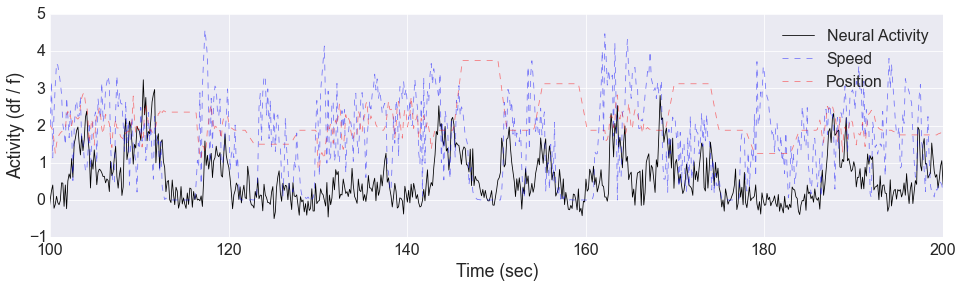

In [19]:
# Time window to view
start = 100
stop = 200

def disp(neuron):
    sns.set_style('darkgrid');
    plt.figure(figsize=(16, 4));
    x = np.arange(n_samp) / hz
    plt.plot(x, ts[neuron, :], c='k', linewidth=0.8);
    plt.xlabel('Time (sec)');
    plt.ylabel('Activity (df / f)');
    
    plt.plot(x, covariates.speed / 16, '--b', alpha=0.5, linewidth=0.8);
    plt.plot(x, covariates.corPos / 8, '--r', alpha=0.5, linewidth=0.8);
    plt.xlim(start, stop);
    plt.ylim(-1, 5);
    plt.legend(['Neural Activity', 'Speed', 'Position']);
    
widgets.interact(disp, neuron = (0, n - 1, 1));

## Learn covariance dictionary using ADMM

#### Compute sample covariance over time

In [20]:
win = np.max([n + 1, 2 * hz]) # time window should be at least as many samples as neurons
shift = 0.2
X = np.vstack([np.cov(ts[:, i : i + win])[np.triu_indices(n)] for i in np.arange(0, n_samp - win, shift * win)]).T
n_win = X.shape[1]

#### Run ADMM

In [23]:
k = 6 # number of dictionary elements
admm = covdict.CovarianceDictionary(k=k, method='admm', verbose=True, time=True, admm_gamma=0.5)
t = time.time()
Wadmm = admm.fit_transform(X)
print str(time.time() - t) + ' seconds'

Iter: 0. Objective: 0.989892.
Iter: 100. Objective: 0.681070.
Iter: 176. Objective: 0.669408.
8.30136799812 seconds


#### Plot objective per iteration

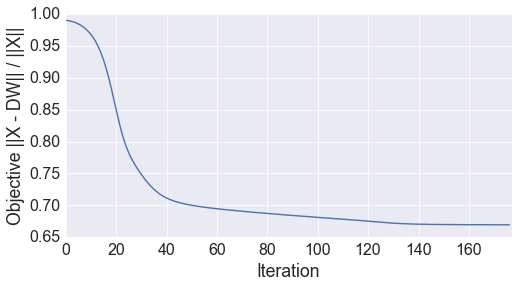

In [25]:
sns.set_style('darkgrid');
plt.figure(figsize=(8, 4));
plt.plot(admm.objective);
plt.xlim(0, admm.objective.size);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

#### Compute average covariate values per time window

In [143]:
reg_names = ['xSpeed', 'ySpeed', 'corPos']
names = ['X Speed', 'Y Speed', 'Corr. Pos.'] # regressor names for plot labels
reg_idx = [np.where(name == covariates.keys())[0][0] for name in reg_names]
n_reg = len(reg_names)
regressors = np.vstack([np.mean(covariates.loc[i : i + win, :], axis=0) 
                        for i in np.arange(0, n_samp - win, shift * win)])
reg = regressors[:, reg_idx]

#### Plot dictionary weights over time with covariates

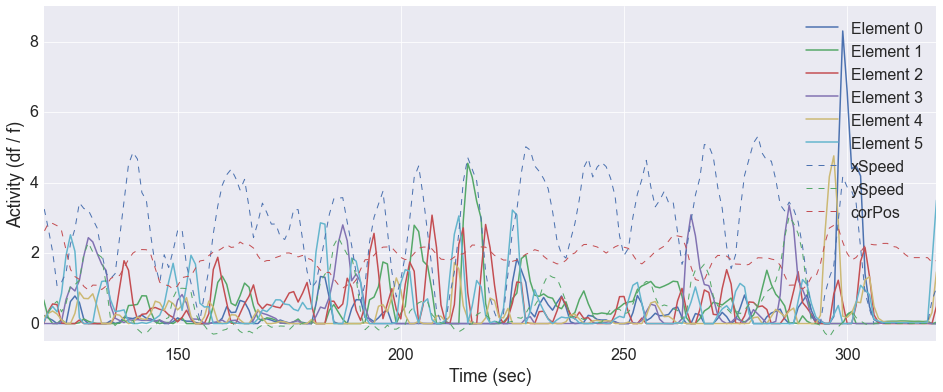

In [31]:
view = 200 # width of time window to view

def disp(start):
    sns.set_style('darkgrid')
    plt.figure(figsize=(16, 6));
    plt.plot(Wadmm.T, linewidth=1.5);
    plt.plot(reg / 8, '--', linewidth=1);    
    plt.xlabel('Time (sec)');
    plt.ylabel('Activity (df / f)');
    plt.xlim(start, start + view);
    plt.ylim(-0.5, 9);
    plt.legend(['Element ' + str(i) for i in range(k)] + reg_names);
    
widgets.interact(disp, start = (0, n_win - view, view / 10));

#### Visualize dictionary elements

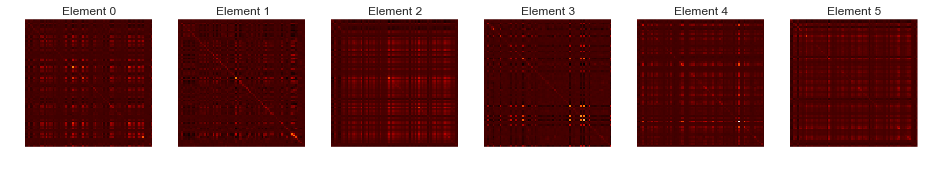

In [34]:
sns.set(rc={'axes.grid':'off', 'figure.facecolor':'white'})
plt.figure(figsize=(16, 4))

vmin = np.min(admm.dictionary)
vmax = np.max(admm.dictionary)

for i in range(k):
    plt.subplot(1, k, i + 1)   
    c = covdict.reform(admm.dictionary[:, i], n)
    plt.imshow(c, interpolation='None', cmap='gist_heat', vmin=vmin, vmax=vmax);
    plt.title('Element ' + str(i));
    plt.axis('off');

## Are the individual tuning and network importance of a neuron related?

#### Linear regression of weights on covariates

In [36]:
lr = LR(fit_intercept=True, normalize=False).fit(scale(reg, axis=0), Wadmm.T)
coef = lr.coef_
icp = lr.intercept_

#### Plot regression coefficients

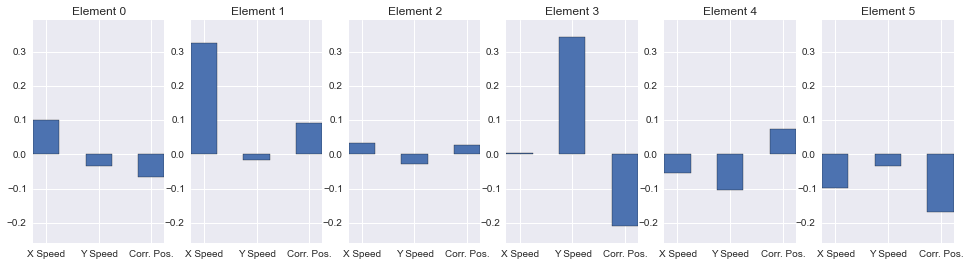

In [149]:
sns.set_style('darkgrid')
plt.figure(figsize=(5.5 * n_reg, 4));

ymin = np.min(coef) - 0.05
ymax = np.max(coef) + 0.05
width = 0.5

for i in range(k):
    plt.subplot(1, k, i + 1);
    plt.title('Element ' + str(i));
    plt.bar(np.arange(n_reg), coef[i, :], width=width);
    plt.xticks(np.arange(n_reg) + width / 2, names);
    plt.ylim(ymin, ymax);

#### Correlation between weights and covariates (simpler model)

In [42]:
cor = np.corrcoef(reg.T, Wadmm)[: n_reg, n_reg :]

#### Plot correlation coefficients

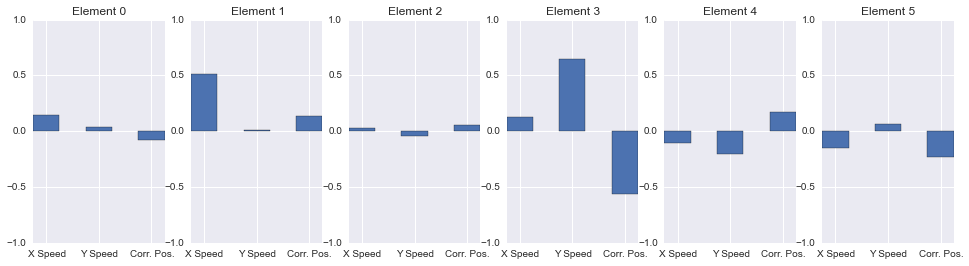

In [148]:
sns.set_style('darkgrid')
plt.figure(figsize=(5.5 * n_reg, 4)); 

for i in range(k):
    plt.subplot(1, k, i + 1);
    plt.title('Element ' + str(i));
    plt.bar(np.arange(n_reg), cor[:, i], width=width);
    plt.xticks(np.arange(n_reg) + width / 2, names);
    plt.ylim(-1, 1);

#### Quantify importance of each neuron in each dictionary element
This measures how much removing a neuron changes the network in the Frobenius norm sense. Other metric?

In [45]:
dictionary = [covdict.reform(admm.dictionary[:, i], n) for i in range(k)]
strength = [np.sum(elem ** 2, axis=0) / np.sum(elem ** 2) for elem in dictionary]

#### Corridor position tuning selectivity of each neuron

In [138]:
# p_tune = table_active.units.pVal.values 
tune = np.std(table_active.tuning.values, axis=1) # variation in tuning curve reflects selectivity

#### Linear regression between network importance and tuning selectivity

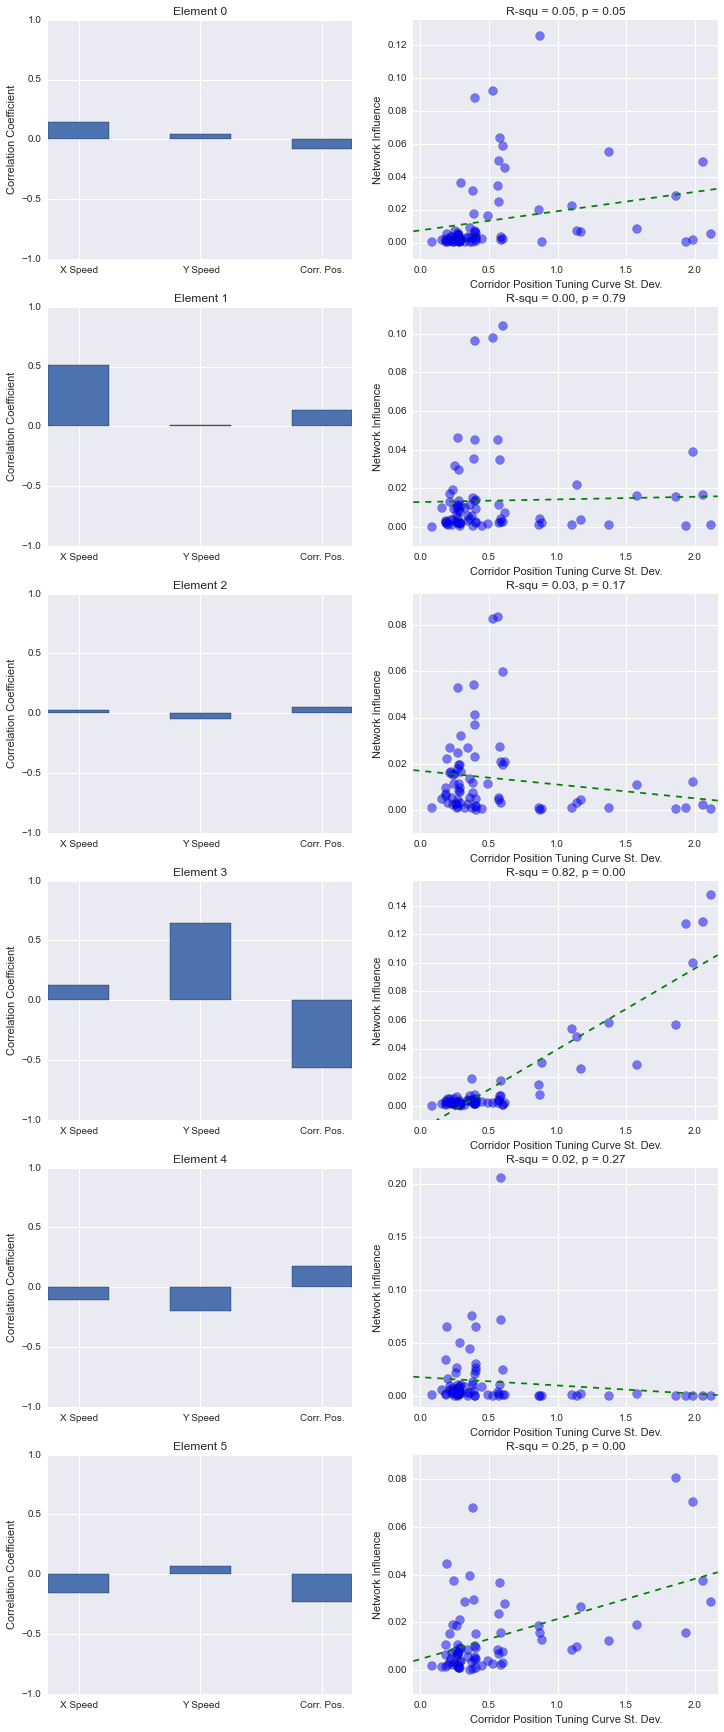

In [189]:
plt.figure(figsize=(12, 5 * k));

xmin = -0.05
xmax = np.max(tune) + 0.05
x = [xmin, xmax]
slope = np.empty(k)
rsqu = np.empty(k)
p_slope = np.empty(k)
 
for i in range(k):
    
    # Plot correlations to behavioral covariates for reference.
    # Note any relationship between correlation to corPos and
    # network importance of highly tuned neurons
    plt.subplot(k, 2, 2 * i + 1);
    plt.bar(np.arange(n_reg), cor[:, i], width=width);
    plt.xticks(np.arange(n_reg) + width / 2, names);
    plt.ylim(-1, 1);
    plt.ylabel('Correlation coefficient');
    plt.title('Element ' + str(i));
    
    # Plot network influence by tuning selectivity
    plt.subplot(k, 2, 2 * (i + 1)); 
    plt.scatter(tune, strength[i], s=80, alpha=0.5);
    plt.xlabel('Corridor position tuning st. dev.');
    plt.ylabel('Network importance');
    plt.xlim(xmin, xmax);
    plt.ylim(np.min(strength[i]) - 0.01, np.max(strength[i]) + 0.01);
    
    # Linear regression
    slope[i], icp, r, p_slope[i], _ = st.linregress(tune, strength[i])
    rsqu[i] = r ** 2
    y = [slope[i] * val + icp for val in x]
    plt.plot(x, y, '--g');
    plt.title('R-squ = %0.2f, p = %0.2f' % (rsqu[i], p_slope[i]));
    


#### Regression between 1) correlation with corridor position and 2) association between network influence and tuning
Shorter way to explain this?

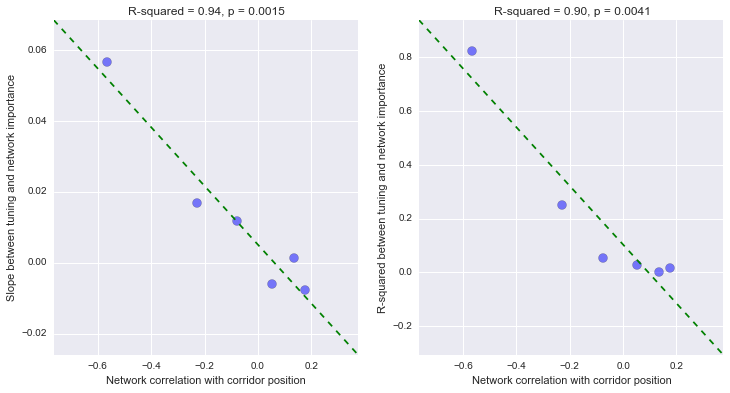

In [200]:
plt.figure(figsize=(12, 6));

# Plot network correlation with corridor position against tuning-vs.-importance slope
plt.subplot(121);
plt.scatter(cor[-1, :], slope, s=80, alpha=0.5);
plt.xlabel('Network correlation with corridor position');
plt.ylabel('Slope between tuning and network importance');

# Best-fit line
sl, ic, r, p, _ = st.linregress(cor[-1, :], slope)
x = [np.min(cor[-1, :]) - 0.2, np.max(cor[-1, :]) + 0.2]
y = [sl * val + ic for val in x]
plt.plot(x, y, '--g');
plt.xlim(x);
plt.ylim(y[::-1]);
plt.title('R-squared = %0.2f, p = %0.4f' % (r ** 2, p));

# Plot network correlation with corridor position against tuning-vs.-importance R-squared
plt.subplot(122);
plt.scatter(cor[-1, :], rsqu, s=80, alpha=0.5);
plt.xlabel('Network correlation with corridor position');
plt.ylabel('R-squared between tuning and network importance');

# Best-fit line
sl, ic, r, p, _ = st.linregress(cor[-1, :], rsqu)
x = [np.min(cor[-1, :]) - 0.2, np.max(cor[-1, :]) + 0.2]
y = [sl * val + ic for val in x]
plt.plot(x, y, '--g');
plt.xlim(x);
plt.ylim(y[::-1]);
plt.title('R-squared = %0.2f, p = %0.4f' % (r ** 2, p));

#### Identify most important neurons of network most correlated to corridor position

In [181]:
n_top = 8 # number of most important neurons to find
corpos_idx = np.argmax(abs(cor[-1, :])) # most correlated dictionary element
idx = np.argsort(strength[corpos_idx])[::-1][: n_top] # most important neurons in this dictionary element
top_idx = table_active.index[idx]

#### Plot tuning curves of most important neurons

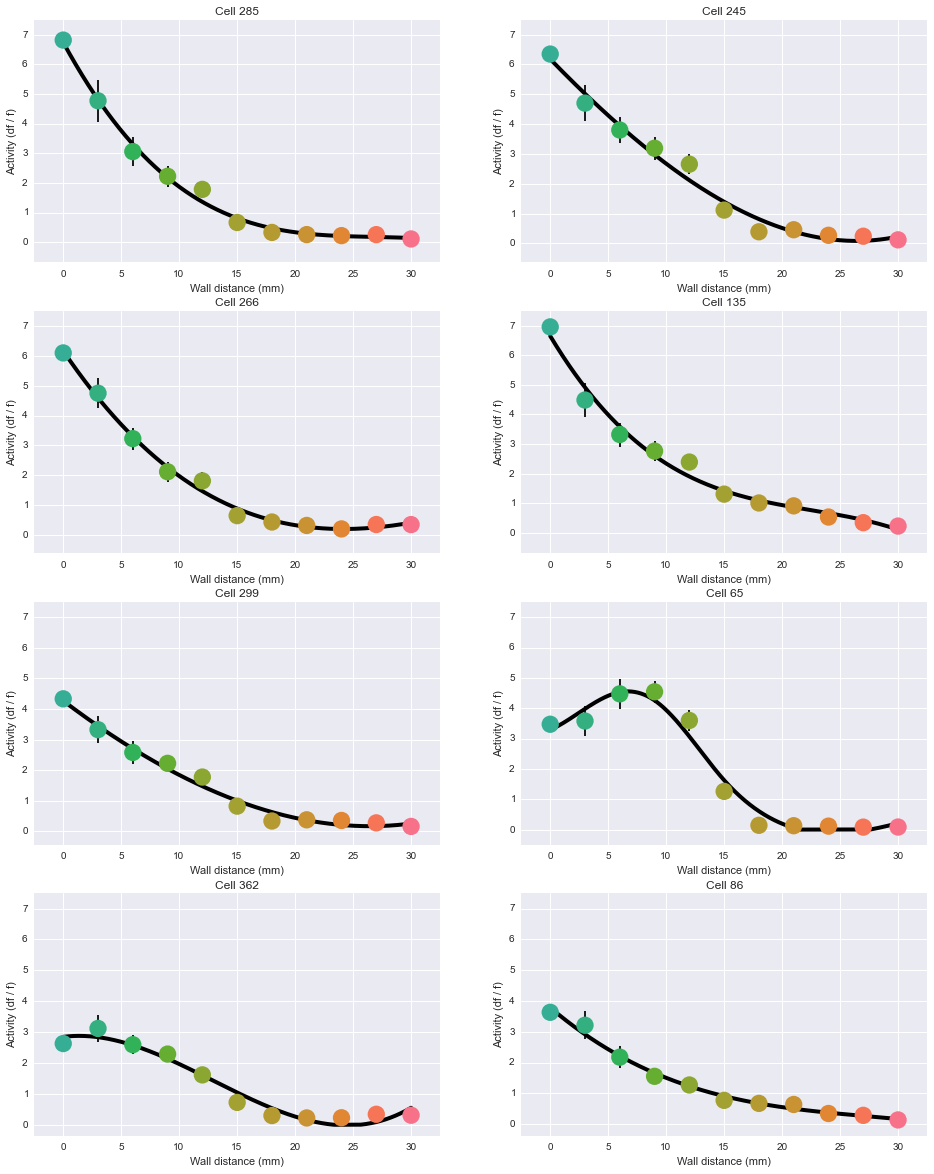

In [184]:
plt.figure(figsize=(16, 5 * n_top / 2));
x = table_active.tuning.columns.values
for i, idx in enumerate(top_idx):
    plt.subplot(np.ceil(n_top / 2), 2, i + 1);
    y = table_active.tuning.loc[idx].values
    err = table_active.tuningErr.loc[idx].values
    tuning(x, y, err, smooth=smooth, ylabel='Activity (df / f)');
    plt.ylim(plt.ylim()[0], 7.5);
    plt.title('Cell ' + str(idx));

#### Identify least important cells of network most correlated to corridor position

In [198]:
n_bot = 8 # number of least important neurons to find
idx = np.argsort(strength[corpos_idx])[: n_bot] # least important neurons in this dictionary element
bot_idx = table_active.index[idx]

#### Plot tuning curves of least important neurons

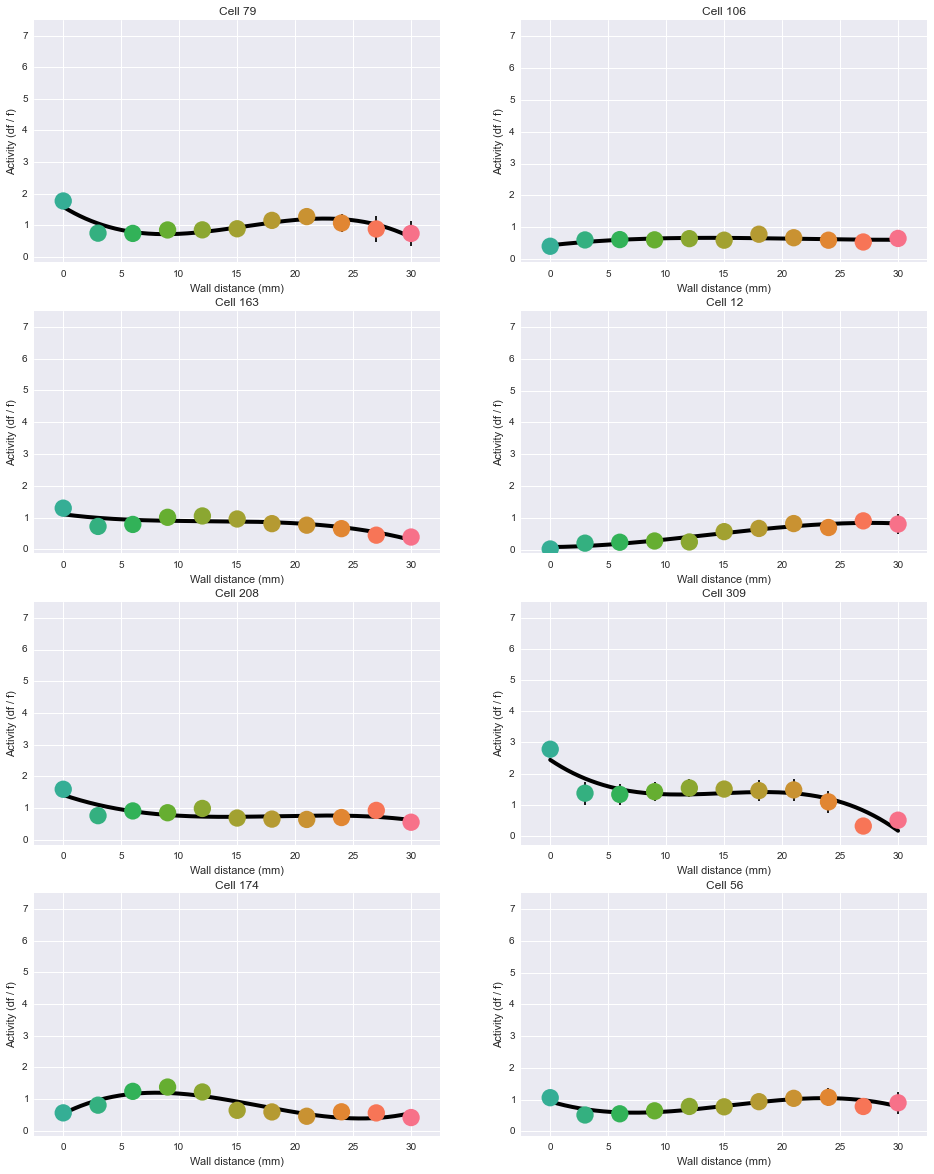

In [199]:
plt.figure(figsize=(16, 5 * n_bot / 2));
x = table_active.tuning.columns.values
for i, idx in enumerate(bot_idx):
    plt.subplot(np.ceil(n_bot / 2), 2, i + 1);
    y = table_active.tuning.loc[idx].values
    err = table_active.tuningErr.loc[idx].values
    tuning(x, y, err, smooth=smooth, ylabel='Activity (df / f)');
    plt.ylim(plt.ylim()[0], 7.5);
    plt.title('Cell ' + str(idx));